# Fantasy Premier League Project 

# ROLLING STATISTICS, DEFENDERS, PCA/SVD

### Libraries 

In [1]:
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

### File reading

In [2]:
#list all csv files

fpl_files_23 = glob.glob('gw*_1.{}'.format('csv')) #fpl 2022-23 files
fpl_23= pd.concat([pd.read_csv(f) for f in fpl_files_23 ], ignore_index=True)

C:\Users\Joseph\AppData\Local\Temp\ipykernel_908\1658855045.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  fpl_23= pd.concat([pd.read_csv(f) for f in fpl_files_23 ], ignore_index=True)


## PREPROCESSING

In [3]:
fpl_23 = fpl_23[fpl_23['position']=='DEF']

In [4]:
#We transform all the strings which represent numeric values, to floats.

fpl_23[['value','total_points','assists','bonus','bps','clean_sheets','element','minutes','goals_conceded','goals_scored','own_goals','penalties_missed','penalties_saved','red_cards','saves','selected','starts','team_a_score','team_h_score','transfers_balance','transfers_in','transfers_out',"yellow_cards"]]=fpl_23[['value','total_points','assists','bonus','bps','clean_sheets','element','minutes','goals_conceded','goals_scored','own_goals','penalties_missed','penalties_saved','red_cards','saves','selected','starts','team_a_score','team_h_score','transfers_balance','transfers_in','transfers_out',"yellow_cards"]].astype(float)

## Checking for missing or NA values.

In [5]:
# First, group by 'name' and 'round' and then take the mean of the matches for players with more than one match in a gameweek
fpl_23 = fpl_23.groupby(['name', 'round']).mean(numeric_only = True).reset_index()

# Now, you can set the index to the aggregated DataFrame
fpl_23.set_index(['name', 'round'], inplace=True)

# And sort the DataFrame by 'name' and 'round' again
fpl_23 = fpl_23.sort_values(by=['name', 'round'])

In [6]:
def rolling_average(series, window):
    return series.rolling(min_periods=1, window=window).mean().shift(1)

def get_player_averages(df, stats):
    """
    Estimate player averages for all stats and FanDuel point histories,
    for season-to-date, last 4 weeks, and previous week
    """
    feature_names = []
    for stat in stats + ['total_points']:
        # Make sure the stat is a column in the dataframe
        if stat in df.columns:
            grouped = df.groupby('name')[stat]  # Group by name
            df['season_{}'.format(stat)] = grouped.transform(lambda x: rolling_average(x, 16))
            df['recent_{}'.format(stat)] = grouped.transform(lambda x: rolling_average(x, 4))
            df['prev_{}'.format(stat)] = grouped.transform(lambda x: rolling_average(x, 1))
            feature_names += [time + "_" + stat for time in ['season', 'recent', 'prev']]
        else:
            raise KeyError(f"The stat '{stat}' was not found in the dataframe.")
    return df, feature_names

# Example usage
stats = ['xP', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'expected_assists', 'expected_goal_involvements',
       'expected_goals', 'expected_goals_conceded', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'minutes', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'saves', 'selected',
       'starts', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'yellow_cards']
# try:
#     fpl_23, feature_names = get_player_averages(fpl_23, stats)
#     print(fpl_23[['season_total_points', 'recent_total_points', 'prev_total_points', 'total_points']].head())
# except KeyError as e:
#     print(e)

get_player_averages(fpl_23, stats)
fpl_23

(                        xP  assists  bonus   bps  clean_sheets  creativity  \
 name            round                                                        
 Aaron Cresswell 1      1.3      0.0    0.0  16.0           0.0        18.7   
                 2      2.0      0.0    0.0  14.0           0.0        65.8   
                 3      1.0      0.0    0.0   6.0           0.0        38.8   
                 4      2.2      0.0    0.0  26.0           1.0         5.8   
                 5      1.7      0.0    0.0  16.0           0.0         1.5   
 ...                    ...      ...    ...   ...           ...         ...   
 Çaglar Söyüncü  34     2.8      0.0    3.0  30.0           0.0         0.4   
                 35     2.8      0.0    0.0  12.0           0.0         0.8   
                 36     0.0      0.0    0.0   0.0           0.0         0.0   
                 37     0.0      0.0    0.0   0.0           0.0         0.0   
                 38     0.0      0.0    0.0   0.0   

### Since we dont care much about any players with barely any game time we tried removing them.

In [7]:
fpl_23.reset_index(inplace=True)

In [8]:
# We repeat the same process as before
player_means = fpl_23.groupby('name')['minutes'].mean()

# Filter for players with mean minutes fewer than 60
players_with_mean_zero = player_means[player_means <60]

# Remove players with mean minutes fewer than 60 from the original DataFrame
fpl_23 = fpl_23[~fpl_23['name'].isin(players_with_mean_zero.index)]

#### Interquaretile Range Method (IQR)

In [9]:
Q1 = fpl_23['total_points'].quantile(0.25)
Q3 = fpl_23['total_points'].quantile(0.75)
IQR = Q3-Q1
upper_whisker = min(Q3 + 1.5*IQR, max(fpl_23['total_points']))
lower_whisker = max(Q1 - 1.5*IQR, min(fpl_23['total_points']))
print("The Upper whisker is {} and the Lower whisker is {}.".format(upper_whisker,lower_whisker))

The Upper whisker is 11.0 and the Lower whisker is -3.0.


### This is our 4 datasets: 
- Dataset with outliers
- Dataset without outliers
- Scaled Dataset with outliers
- Scaled Dataset without outliers

In [10]:
fpl_23.drop(columns = ['xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'minutes', 'own_goals', 'penalties_missed',
       'penalties_saved', 'red_cards', 'saves', 'selected', 'starts',
       'team_a_score', 'team_h_score', 'threat',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'yellow_cards'], inplace=True, axis=1)

C:\Users\Joseph\AppData\Local\Temp\ipykernel_908\2035911875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpl_23.drop(columns = ['xP', 'assists', 'bonus', 'bps', 'clean_sheets',


In [11]:
fpl_23.fillna(0,inplace=True)

C:\Users\Joseph\AppData\Local\Temp\ipykernel_908\3398245620.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpl_23.fillna(0,inplace=True)


In [12]:
#Dataset without outliers
fpl_23_no_outl = fpl_23[ (fpl_23['total_points'] >= lower_whisker) & (fpl_23['total_points'] <= upper_whisker) ]

# Scaled dataset with outliers
fpl_23_scaled = fpl_23.select_dtypes(include=['number'])
fpl_23_scaled = fpl_23_scaled.drop(['total_points'], axis=1)
rscaler = RobustScaler()

robustRescaledX = rscaler.fit_transform(fpl_23_scaled)
fpl_23_scaled = pd.DataFrame(robustRescaledX, columns=fpl_23_scaled.columns)
cols_to_add = ['total_points']

for col in cols_to_add:
    fpl_23_scaled[col] = fpl_23[col].reset_index(drop=True)


# Scaled dataset without outliers
fpl_23_scaled_no_outl = fpl_23_no_outl.select_dtypes(include=['number'])
fpl_23_scaled_no_outl = fpl_23_scaled_no_outl.drop(['total_points'], axis=1)
rscaler2 = RobustScaler()

robustRescaledX2 = rscaler2.fit_transform(fpl_23_scaled_no_outl)
fpl_23_scaled_no_outl = pd.DataFrame(robustRescaledX2, columns=fpl_23_scaled_no_outl.columns)
cols_to_add = ['total_points']

for col in cols_to_add:
    fpl_23_scaled_no_outl[col] = fpl_23_no_outl[col].reset_index(drop=True)

In [13]:
x=fpl_23.select_dtypes(include=['number'])
x=x.drop(columns=['total_points'])
y=fpl_23['total_points']

In [14]:
x_no_outl=fpl_23_no_outl.select_dtypes(include=['number'])
x_no_outl=x_no_outl.drop(columns=['total_points'])
y_no_outl=fpl_23_no_outl['total_points']

In [15]:
x_scaled=fpl_23_scaled.select_dtypes(include=['number'])
x_scaled=x_scaled.drop(columns=['total_points'])
# we use the y for our target value here

In [16]:
x_scaled_no_outl=fpl_23_scaled_no_outl.select_dtypes(include=['number'])
x_scaled_no_outl=x_scaled_no_outl.drop(columns=['total_points'])
# we use the y_no_outl for our target value here

#### Classification
Class 1: below or equal 0 points   
Class 2: 1 points    
Class 3: 2 points  
Class 4: from 3 to 6 points  
Class 5: from 7 to 9 points  
Class 6: from 10 points and above

In [17]:
# new Y for classification for the dataset with outliers
ycl = pd.cut(y, bins = [-np.inf, 0, 1, 2, 6, 9, np.inf], labels =['Class 1','Class 2','Class 3','Class 4','Class 5','Class 6'])

In [18]:
# new Y for classification for the dataset without outliers
y_no_outl_cl = pd.cut(y_no_outl, bins = [-np.inf, 0, 1, 2, 6, 9, np.inf], labels =['Class 1','Class 2','Class 3','Class 4','Class 5','Class 6'])

# PCA

TruncatedSVD explained variance ratio (first first  30 components components): [0.34692017 0.1882435  0.09285717 0.07116816 0.05921621 0.03172502
 0.02694961 0.02533055 0.01921266 0.01703434 0.01337067 0.01211395
 0.00906276 0.00826045 0.00749229 0.00654419 0.00559065 0.00535172
 0.00454245 0.00461693 0.00434443 0.00404229 0.00376675 0.0033524
 0.00300529 0.00274595 0.00201218 0.00194558 0.00181762 0.00161571]
Total variance explained by created features: 98.42516407272292 %


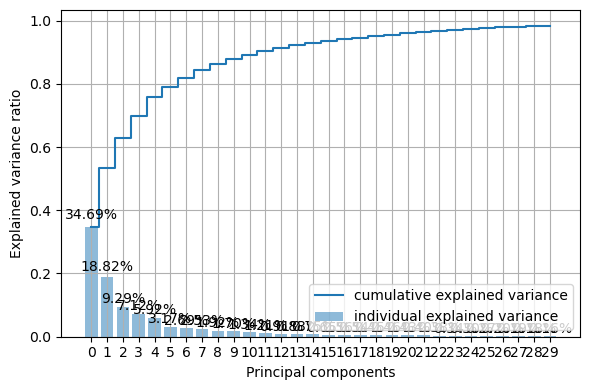

PCA explained variance ratio (first first  30 components components): [0.35577625 0.18838101 0.09398423 0.07015884 0.05577305 0.03194297
 0.02614558 0.02404387 0.0192126  0.01650595 0.01296365 0.01171695
 0.00888689 0.00812492 0.00696368 0.00654406 0.00557996 0.00532095
 0.0046171  0.00438559 0.00411063 0.00388392 0.00369025 0.0032844
 0.00300275 0.00266543 0.00199346 0.00192527 0.00180676 0.00160863]
Total variance explained by created features: 98.49995949602595 %


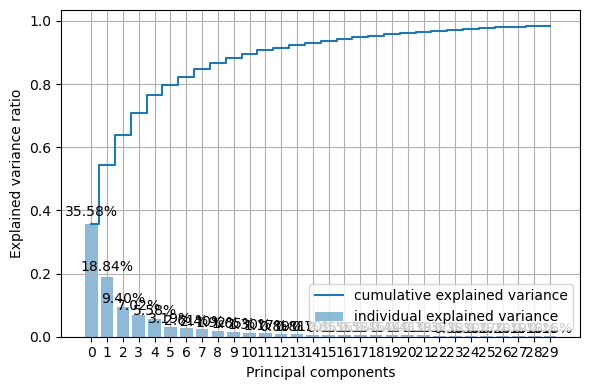

In [19]:
# Truncated SVD
from sklearn.decomposition import TruncatedSVD
# PCA
from sklearn.decomposition import PCA
# Linear Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# function that plots the variance explained by each new feature
def print_variance_explained_plot(obj, n_components):
    cum_var_exp = np.cumsum(obj.explained_variance_ratio_)
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(range(n_components), obj.explained_variance_ratio_, alpha=0.5, align='center',
                label='individual explained variance')
    # show percentage of explained variance on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., 1.05*height, '%.2f%%' % (height*100), 
                ha='center', va='bottom')
    plt.step(range(n_components), cum_var_exp, where='mid',
                 label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.xticks( range(n_components) )
    plt.grid(True)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def print_2d_scatter_plot(features, target, title):
    newDf=pd.DataFrame(features, columns=['Feature '+str(i) for i in range(features.shape[1])])
    newDf['target']=target
    sns.scatterplot(data=newDf, x='Feature 0', y='Feature 1', hue='target').set(title=title)

# number of components (new features) to be extracted by SVD and PCA. Set to 6.
num_of_components = 30

# create the TruncatedSVD object with n_components equal to the num_of_components variable above
tsvd = TruncatedSVD(num_of_components)
# train tsvd object and transform X_scaled to create the new dataset based on the newly created features
fpl_23_tsvd = tsvd.fit_transform(x_scaled)
# Percentage of variance explained for each components
print('TruncatedSVD explained variance ratio (first first ',num_of_components, 'components components): %s'
      % str(tsvd.explained_variance_ratio_))
print('Total variance explained by created features:', sum(tsvd.explained_variance_ratio_)*100, '%')
# print explained variance plot
print_variance_explained_plot(tsvd,num_of_components)

# create the PCA object with n_components equal to the num_of_components variable above
pca = PCA(n_components=num_of_components)
# train pca object and transform X_scaled to create the new dataset based on the newly created features
fpl_23_pca = pca.fit_transform(x_scaled)
print('PCA explained variance ratio (first first ',num_of_components, 'components components): %s'
      % str(pca.explained_variance_ratio_))
print('Total variance explained by created features:', sum(pca.explained_variance_ratio_)*100, '%')
# print explained variance plot
print_variance_explained_plot(pca,num_of_components)

In [20]:
fpl_23_tsvd = pd.DataFrame(fpl_23_tsvd)

In [21]:
fpl_23_pca = pd.DataFrame(fpl_23_pca)

#### Feature selection - Classifcation

best combination (ACC: 0.223): (0, 2, 3, 4, 11, 12, 13, 14, 18, 19, 20, 25)

all subsets:
 {1: {'feature_idx': (14,), 'cv_scores': array([0.18240669, 0.21125478, 0.19606142, 0.20637911, 0.21298808]), 'avg_score': 0.20181801641774047, 'feature_names': (14,)}, 2: {'feature_idx': (2, 14), 'cv_scores': array([0.2031511 , 0.18593836, 0.1500086 , 0.23499775, 0.23674348]), 'avg_score': 0.2021678590789307, 'feature_names': (2, 14)}, 3: {'feature_idx': (2, 11, 14), 'cv_scores': array([0.17584927, 0.2509981 , 0.20623116, 0.1995197 , 0.2154491 ]), 'avg_score': 0.20960946499516755, 'feature_names': (2, 11, 14)}, 4: {'feature_idx': (2, 11, 14, 25), 'cv_scores': array([0.20137668, 0.24811202, 0.20595871, 0.22090159, 0.19419437]), 'avg_score': 0.21410867428345237, 'feature_names': (2, 11, 14, 25)}, 5: {'feature_idx': (2, 11, 14, 18, 25), 'cv_scores': array([0.22496225, 0.20834961, 0.18166891, 0.20229546, 0.23466209]), 'avg_score': 0.21038766152761146, 'feature_names': (2, 11, 14, 18, 25)}, 6: {'featu

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: xlabel='Number of Features', ylabel='Performance'>)

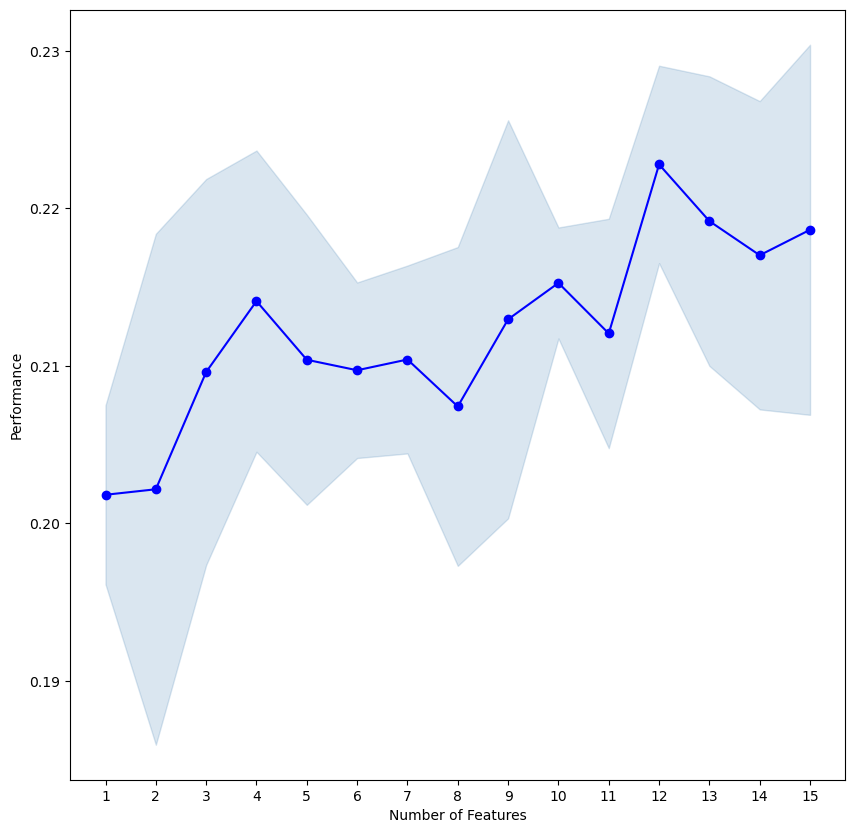

In [23]:
# extract Features and target variables
from sklearn.linear_model  import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier # Decision Tree Classifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.naive_bayes import GaussianNB #Naive Bayes Classifier
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score, average='macro')

rfc = RandomForestClassifier()
sfs_range = SFS(estimator=rfc, 
           k_features=(2, 30),
           forward=True, 
           floating=False, 
           scoring=f1,
           cv=5)

sfs_range = sfs_range.fit(fpl_23_tsvd, ycl)

print('best combination (ACC: %.3f): %s\n' % (sfs_range.k_score_, sfs_range.k_feature_idx_))
print('all subsets:\n', sfs_range.subsets_)
plt.rcParams["figure.figsize"] = (10,10)
plot_sfs(sfs_range.get_metric_dict(), kind='std_err')

In [24]:
# extract Features and target variables
from sklearn.linear_model  import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier # Decision Tree Classifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.naive_bayes import GaussianNB #Naive Bayes Classifier
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score, average='macro')

rfc = RandomForestClassifier()
sfs_range = SFS(estimator=rfc, 
           k_features=(2, 30),
           forward=True, 
           floating=False, 
           scoring=f1,
           cv=5)

sfs_range = sfs_range.fit(fpl_23_pca, ycl)

print('best combination (ACC: %.3f): %s\n' % (sfs_range.k_score_, sfs_range.k_feature_idx_))
print('all subsets:\n', sfs_range.subsets_)
plt.rcParams["figure.figsize"] = (10,10)
plot_sfs(sfs_range.get_metric_dict(), kind='std_err')


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

TypeError: must be real number, not NoneType

In [ ]:
best_feature_names = fpl_23_pca.columns[list(sfs_range.k_feature_idx_)]
best_feature_names

In [ ]:
X_sfs_pca = fpl_23_pca.iloc[:,[0, 2, 4, 5, 6, 8, 12, 17, 18, 19, 20, 23, 25, 26, 27]]
#X_sfs = sfs_range.transform(x)

# ME PCA

In [ ]:
#Dividing data into test & train splitting 80% data for training anf 20% for test
X_train, X_test, y_train, y_test = train_test_split(X_sfs_pca, ycl, test_size=0.20)
print('There are {} samples in the training set and {} samples in the test set'.format(X_train.shape[0], X_test.shape[0]))

In [ ]:
# Machine Learning Library
from sklearn.preprocessing import LabelEncoder # Encode Categorical Variable to Numerical Variable
from sklearn.impute import SimpleImputer # Imputer Class to replace missing values
from sklearn.metrics import confusion_matrix # Library for model evaluation
from sklearn.metrics import accuracy_score # Library for model evaluation
from sklearn.model_selection import train_test_split # Library to split datset into test and train
 
from sklearn.linear_model  import LogisticRegression # Logistic Regression Classifier
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent Classifier
from sklearn.tree import DecisionTreeClassifier # Decision Tree Classifier
from sklearn.ensemble  import RandomForestClassifier # Random Forest Classifier
from sklearn.neighbors import KNeighborsClassifier # K Nearest neighbors Classifier
from sklearn.naive_bayes import GaussianNB #Naive Bayes Classifier
from sklearn.svm import SVC #Support vector Machine Classifier
from sklearn.ensemble import AdaBoostClassifier # Ada Boost Classifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
 
plt.rcParams["figure.figsize"] = (5,5)
 
# Making a list of all classifiers
classifier_model = [GaussianNB(), SVC(), DecisionTreeClassifier(), RandomForestClassifier(), SGDClassifier(), AdaBoostClassifier()]
 
# Creating empty list to store the performance details
classifier_model_list= []
classifier_accuracy_test = []
classifier_accuracy_train = []
f1score = []
precisionscore = []
recallscore = []
#avg_pre_rec_score = []
cv_score = []
 
 
for classifier_list in classifier_model:
    classifier = classifier_list
    # Fitting the training set into classification model
    classifier.fit(X_train,y_train)
    # Predicting the output on test dataset
    y_pred_test = classifier.predict(X_test)    
    score_test = accuracy_score(y_test, y_pred_test)
    # Predicting the output on training datset
    y_pred_train = classifier.predict(X_train) 
    score_train = accuracy_score(y_train, y_pred_train)
    # Cross Validation Score on training test
    scores = cross_val_score(classifier, X_train,y_train, cv=10)
    cv_score.append(scores.mean())
    #Keeping the model and accuracy score into a list
    classifier_model_list.append(classifier_list.__class__.__name__)
    classifier_accuracy_test.append(round(score_test,4))
    classifier_accuracy_train.append(round(score_train,4))
    #Precision, Recall and F1 score
    f1score.append(f1_score(y_test, y_pred_test, average='macro'))
    precisionscore.append(precision_score(y_test, y_pred_test, average='macro', zero_division=0))
    recallscore.append(recall_score(y_test, y_pred_test, average='macro'))

In [ ]:
#Creating pandas dataframe with Model and corresponding accuracy
#accuracy_df = pd.DataFrame({'Model':classifier_model_list , 'Test Accuracy':classifier_accuracy_test, 'Train Accuracy' :classifier_accuracy_test , 'Precision':precisionscore, 'Recall':recallscore ,'F1 Score':f1score},index=None)
accuracy_df = pd.DataFrame({'Model':classifier_model_list , 'Cross Val Score':cv_score, 'Test Accuracy' :classifier_accuracy_test , 'Precision':precisionscore, 'Recall':recallscore, 'F1 Score':f1score})

# Calculating Average Accuracy = (Test + Train)/2
accuracy_df['Average_Accuracy'] =  (accuracy_df['Cross Val Score'] + accuracy_df['Test Accuracy'] )/ 2

#Arranging the Columns
print("\n*------------------------------    CLASSIFICATION MODEL PERFORMANCE EVALUATION      ---------------------*\n")
accuracy_df = accuracy_df[['Model','Cross Val Score', 'Test Accuracy', 'Average_Accuracy','Precision', 'Recall', 'F1 Score']]  # This will arrange the columns in the order we want

#Sorting the Columns based on Average Accuracy
accuracy_df.sort_values('Average_Accuracy', axis=0, ascending=False, inplace=True) # Sorting the data with highest accuracy in the top
accuracy_df
#accuracy_df.transpose()

# ME SVD

In [ ]:
X_sfs_tsvd = fpl_23_tsvd.iloc[:,[0, 2, 4, 5, 6, 8, 12, 17, 18, 19, 20, 23, 25, 26, 27]]

In [ ]:
#Dividing data into test & train splitting 80% data for training anf 20% for test
X_train, X_test, y_train, y_test = train_test_split(X_sfs_tsvd, ycl, test_size=0.20)
print('There are {} samples in the training set and {} samples in the test set'.format(X_train.shape[0], X_test.shape[0]))

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
 
# Making a list of all classifiers
classifier_model = [GaussianNB(), SVC(), DecisionTreeClassifier(), RandomForestClassifier(), SGDClassifier(), AdaBoostClassifier()]
 
# Creating empty list to store the performance details
classifier_model_list= []
classifier_accuracy_test = []
classifier_accuracy_train = []
f1score = []
precisionscore = []
recallscore = []
#avg_pre_rec_score = []
cv_score = []
 
 
for classifier_list in classifier_model:
    classifier = classifier_list
    # Fitting the training set into classification model
    classifier.fit(X_train,y_train)
    # Predicting the output on test dataset
    y_pred_test = classifier.predict(X_test)    
    score_test = accuracy_score(y_test, y_pred_test)
    # Predicting the output on training datset
    y_pred_train = classifier.predict(X_train) 
    score_train = accuracy_score(y_train, y_pred_train)
    # Cross Validation Score on training test
    scores = cross_val_score(classifier, X_train,y_train, cv=10)
    cv_score.append(scores.mean())
    #Keeping the model and accuracy score into a list
    classifier_model_list.append(classifier_list.__class__.__name__)
    classifier_accuracy_test.append(round(score_test,4))
    classifier_accuracy_train.append(round(score_train,4))
    #Precision, Recall and F1 score
    f1score.append(f1_score(y_test, y_pred_test, average='macro'))
    precisionscore.append(precision_score(y_test, y_pred_test, average='macro', zero_division=0))
    recallscore.append(recall_score(y_test, y_pred_test, average='macro'))

In [ ]:
#Creating pandas dataframe with Model and corresponding accuracy
#accuracy_df = pd.DataFrame({'Model':classifier_model_list , 'Test Accuracy':classifier_accuracy_test, 'Train Accuracy' :classifier_accuracy_test , 'Precision':precisionscore, 'Recall':recallscore ,'F1 Score':f1score},index=None)
accuracy_df = pd.DataFrame({'Model':classifier_model_list , 'Cross Val Score':cv_score, 'Test Accuracy' :classifier_accuracy_test , 'Precision':precisionscore, 'Recall':recallscore, 'F1 Score':f1score})

# Calculating Average Accuracy = (Test + Train)/2
accuracy_df['Average_Accuracy'] =  (accuracy_df['Cross Val Score'] + accuracy_df['Test Accuracy'] )/ 2

#Arranging the Columns
print("\n*------------------------------    CLASSIFICATION MODEL PERFORMANCE EVALUATION      ---------------------*\n")
accuracy_df = accuracy_df[['Model','Cross Val Score', 'Test Accuracy', 'Average_Accuracy','Precision', 'Recall', 'F1 Score']]  # This will arrange the columns in the order we want

#Sorting the Columns based on Average Accuracy
accuracy_df.sort_values('Average_Accuracy', axis=0, ascending=False, inplace=True) # Sorting the data with highest accuracy in the top
accuracy_df
#accuracy_df.transpose()